# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is 2 fold. 
 1. To identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image. This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".
 2. To prepare a training script to run in a distributed ML environment


## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [21]:
!pip install opencv-python
!pip install matplotlib
!pip install tensorflow==2.4.1
!pip install keras==2.3.1

In [22]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings

import azureml
from azureml.core import Experiment
from azureml.core import Workspace, Run
from azureml.core import Environment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.telemetry import set_diagnostics_collection
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.authentication import InteractiveLoginAuthentication

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from platform import python_version

import random as rn
import tensorflow as tf
import keras as k

rn.seed(30)
np.random.seed(30)
tf.compat.v1.random.set_random_seed(30)
print(python_version())
set_diagnostics_collection(send_diagnostics=False)
print(tf.__version__)
warnings.simplefilter('ignore')


3.8.1
2.3.0


In [23]:
interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")
ws = Workspace(subscription_id="925a5ad8-a21a-48c0-92a2-5a8a2a4dfc46",
               resource_group="ml-workbench",
               workspace_name="ml-workbench-eu",
               auth=interactive_auth)

In [24]:
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [25]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: ml-workbench-eu
Azure region: eastus
Subscription id: 925a5ad8-a21a-48c0-92a2-5a8a2a4dfc46
Resource group: ml-workbench


In [26]:
tf_env = Environment.from_conda_specification(name='tensorflow-2.2-gpu', file_path='AzureML-TensorFlow-2.2-GPU/conda_dependencies.yml')


Download the dataset from google drive onto the Azure Compute Machine. 

In [27]:
from azureml.core.dataset import Dataset

web_paths = [
                'https://mlworkbencheu2397988138.blob.core.windows.net/datasets/data.zip'
            ]
dataset = Dataset.File.from_files(path=web_paths)

Registering the dataset so that it can be used across workspace

In [28]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'effusion-dataset')
    dataset_registered = True
except:
    print("The dataset effusion-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'effusion-dataset',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/data.zip']

Configure Compute Target

In [29]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-instance-small"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
except ComputeTargetException:
    print('Compute Target does not exist...')

In [30]:
dataset.download('/tmp/data/', overwrite=True)

In [ ]:
# !mkdir -p /var/tmp/effusion
# !cp /tmp/data/data.zip /var/tmp/effusion
# !unzip -qq -o /var/tmp/effusion/data.zip -d /var/tmp/effusion/

In [ ]:
DATASET_PATH = '/var/tmp/effusion/data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

In [ ]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = cv2.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = cv2.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [ ]:
effusion.shape, normal.shape

In [ ]:
resized_img = cv2.resize(effusion, (256,256), interpolation = cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
print(resized_img.shape)

In [ ]:
# Normalized Image
normalizedImg = np.zeros((256, 256))
plt.imshow(cv2.normalize(resized_img, normalizedImg, 0, 255, cv2.NORM_MINMAX))

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    normalizedImg = np.zeros((256, 256))
    resized_img = cv2.resize(img, (256,256))
    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)[:,:,np.newaxis]
    if mode == 'train':
        if np.random.randn() > 0:
            normalized_img = datagen.random_transform(normalized_img)
    return normalized_img

## 2. Model building

Let us build a CNN model.

In [ ]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [ ]:
img_channels = 1
img_rows = 256
img_cols = 256
nb_classes = 2

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_rows,img_cols,img_channels)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu',))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(256))
cnn.add(Dense(nb_classes,activation='softmax'))
cnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
cnn.summary()


In [ ]:
import numpy as np

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID, cv2.IMREAD_GRAYSCALE)
            img = img[:, :, np.newaxis]
            if img.shape[:3] == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, k.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

An ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [20]:
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

cnn.fit(training_generator, epochs=1, validation_data=validation_generator)

NameError: name 'AugmentedDataGenerator' is not defined

In [58]:
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

cnn.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 0s 71ms/step - loss: 2.7165 - accuracy: 0.9062 - auc: 0.9062
Epoch 2/5
1/1 [==============================] - 0s 68ms/step - loss: 0.5766 - accuracy: 0.9375 - auc: 0.9375
Epoch 3/5
1/1 [==============================] - 0s 72ms/step - loss: 0.3121 - accuracy: 0.9375 - auc: 0.9062
Epoch 4/5
1/1 [==============================] - 0s 72ms/step - loss: 0.3116 - accuracy: 0.9062 - auc: 0.9180
Epoch 5/5
1/1 [==============================] - 0s 68ms/step - loss: 0.3121 - accuracy: 0.9062 - auc: 0.9111


In [59]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [60]:
training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

history = cnn.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8938 - auc: 0.8792
Val AUC for epoch0: 0.5402298850574713
5/5 [==============================] - 4s 787ms/step - loss: 0.4233 - accuracy: 0.8938 - auc: 0.8792 - val_loss: 0.2389 - val_accuracy: 0.9375 - val_auc: 0.9561
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.9125 - auc: 0.9321
Val AUC for epoch1: 0.6166666666666667
5/5 [==============================] - 3s 608ms/step - loss: 0.2923 - accuracy: 0.9125 - auc: 0.9321 - val_loss: 0.3565 - val_accuracy: 0.9062 - val_auc: 0.9043
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9125 - auc: 0.9214
Val

In [68]:
history.history

{'loss': [0.4233080744743347,
  0.2923380732536316,
  0.30282750725746155,
  0.2902472913265228,
  0.31616562604904175],
 'accuracy': [0.893750011920929,
  0.9125000238418579,
  0.9125000238418579,
  0.918749988079071,
  0.90625],
 'auc': [0.8792187571525574,
  0.9320703148841858,
  0.9213671684265137,
  0.9300390481948853,
  0.9136327505111694],
 'val_loss': [0.2389407604932785,
  0.3564857244491577,
  0.2891330420970917,
  0.33278727531433105,
  0.33085933327674866],
 'val_accuracy': [0.9375, 0.90625, 0.9375, 0.90625, 0.90625],
 'val_auc': [0.5402298850574713,
  0.6166666666666667,
  0.5402298850574714,
  0.5057471264367817,
  0.5287356321839081]}

## 4. Final Run


After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [24]:
from keras import backend as kb
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        kb.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(kb.get_value(self.model.optimizer.lr))
        kb.set_value(self.model.optimizer.lr, new_lr)

In [25]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

cnn.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
27/27 [==============================] - 26s 948ms/step - loss: 0.3237 - accuracy: 0.9074 - auc: 0.9148 - val_loss: 0.3256 - val_accuracy: 0.9010 - val_auc: 0.9218

Val AUC for epoch0: 0.58685731670216

Epoch 00001: val_auc improved from -inf to 0.92177, saving model to models/best_model.hdf5
Epoch 2/10
27/27 [==============================] - 25s 931ms/step - loss: 0.3210 - accuracy: 0.9028 - auc: 0.9174 - val_loss: 0.3237 - val_accuracy: 0.9010 - val_auc: 0.9195

Val AUC for epoch1: 0.6133252205658655

Epoch 00002: val_auc did not improve from 0.92177
Epoch 3/10
27/27 [==============================] - 26s 932ms/step - loss: 0.3106 - accuracy: 0.9051 - auc: 0.9244 - val_loss: 0.3238 - val_accuracy: 0.9010 - val_auc: 0.9215

Val AUC for epoch2: 0.6316860465116279

Epoch 00003: val_auc did not improve from 0.92177
Epoch 4/10
27/27 [==============================] - 26s 947ms/step - l

## 5. Making a Prediction

In [29]:
from tensorflow.keras.models import load_model
final_model = load_model('models/best_model.hdf5')

/var/tmp/effusion/data/nofinding/00007241_000.png


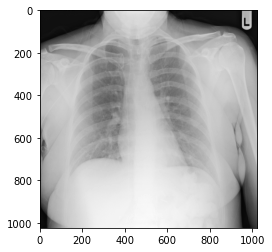

In [34]:
validation_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
validations = glob.glob(validation_path)
image_id = np.random.randint(0, len(validations))
print(validations[image_id])
validation = cv2.imread(validations[image_id], cv2.IMREAD_GRAYSCALE)
plt.imshow(validation,cmap='gray')

In [35]:
img = preprocess_img(validation[:, :, np.newaxis], 'validation')
final_model.predict(img[np.newaxis,:])

array([[0.9103377 , 0.08966228]], dtype=float32)

### 6. Submitting Experiments using ScriptRunConfig

From the above experiements we find out the best model and create a training script

In [18]:
import os
from azureml.core import ScriptRunConfig
import shutil
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

project_folder = './effusion_detector'
os.makedirs(project_folder, exist_ok=True)
shutil.copy('effusion_detector.py', project_folder)

experiment_name = 'tf-effusion-detector'
experiment = Experiment(ws, name=experiment_name)

tf_env = Environment("tensorflow-2.2-gpu")

packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults', 'opencv-python==3.3.0.9', 'matplotlib', 'keras<=2.3.1', 'azureml-sdk', 'azureml-widgets', 'tensorflow'])

tf_env.python.conda_dependencies = packages

# Specify a GPU base image
# tf_env.docker.enabled = True
# tf_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

src = ScriptRunConfig(source_directory=project_folder,
                      script='effusion_detector.py',
                      arguments=['--data-folder', dataset.as_mount()],
                      compute_target=compute_target,
                      environment=tf_env)

run = experiment.submit(src)
print(run)
run.get_details()

Run(Experiment: tf-effusion-detector,
Id: tf-effusion-detector_1620548640_c3109fb2,
Type: azureml.scriptrun,
Status: Starting)


{'runId': 'tf-effusion-detector_1620548640_c3109fb2',
 'target': 'gpu-instance-small',
 'status': 'Starting',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '894d94c9-46b9-4319-9f6e-1a883c76ab76'},
 'inputDatasets': [{'dataset': {'id': '936fc596-dc32-48e8-8ba5-dcbc3bf2b310'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__37544821', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'effusion_detector.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder', 'DatasetConsumptionConfig:input__37544821'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'gpu-instance-small',
  'dataReferences': {},
  'data': {'input__37544821': {'dataLocation': {'dataset': {'id': '936fc596-dc32-48e8-8ba5-dcbc3bf2b310',
      'name': None,
      'version': None},
     'dataPath': None},
    'mechanism': 'Mount',
    'environmentVariableName': 'input__3754

In [19]:

from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…